In [1]:
import matplotlib.pyplot as plt
import torch
from data import load_dataset_and_make_dataloaders
import utils

gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if gpu else "cpu")

In [2]:
dl, info = load_dataset_and_make_dataloaders(
    dataset_name='FashionMNIST',
    root_dir='data', # choose the directory to store the data 
    batch_size=5,
    num_workers=0,   # you can use more workers if you see the GPU is waiting for the batches
    pin_memory=gpu,  # use pin memory if you're planning to move the data to GPU
)

print(info)

for y, label in dl.train:
    imgs = y
    print(y.shape)
    print(label.shape)
    break

DataInfo(image_channels=1, image_size=32, num_classes=10, sigma_data=tensor(0.6625))
torch.Size([5, 1, 32, 32])
torch.Size([5])


In [3]:
sigmas = utils.build_sigma_schedule(10)
noisy_imgs = utils.noising_process(imgs, sigmas)

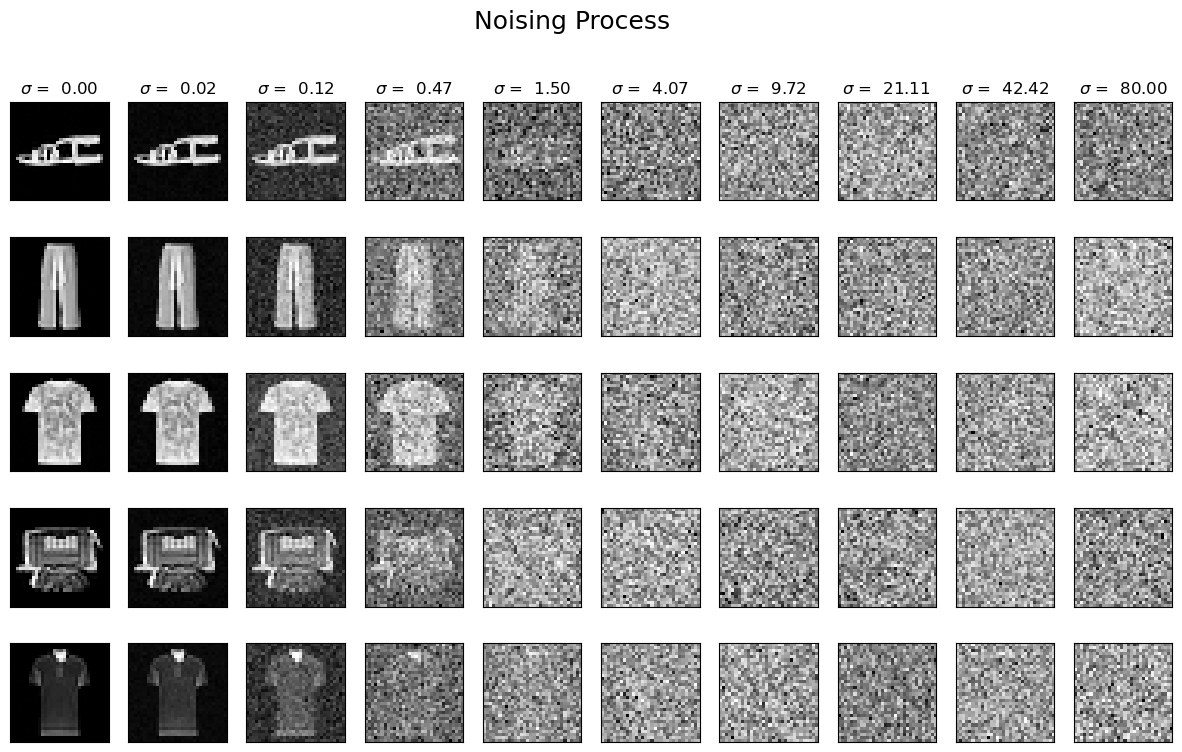

In [5]:
utils.plot_imgs(noisy_imgs, sigmas, plot_name="noising_process", plot_title="Noising Process")

In [6]:
sigma_data = info.sigma_data.to(device)

def c_in(sigma):
    return 1. / torch.sqrt(sigma**2 + sigma_data**2)

def c_out(sigma):
    return sigma * sigma_data / torch.sqrt(sigma**2 + sigma_data**2)

def c_skip(sigma):
    return sigma_data**2 / (sigma**2 + sigma_data**2)

def c_noise(sigma):
    return torch.log(sigma) / 4.

def N(y, sigma): 
    return y + sigma * torch.randn(*y.shape, device=device)

In [ ]:
from model import Model, Model2, Model3

model = Model(image_channels=1, nb_channels=8, num_blocks=5, cond_channels=64).to(device)
# model = Model2(image_channels=1, nb_channels=64, num_blocks=3, cond_channels=64).to(device)
# model = Model3(image_channels=1, nb_channels=64, num_blocks=3, cond_channels=64).to(device)
F = model.forward

def D(x, sigma):
    return c_skip(sigma) * x + c_out(sigma) * F(c_in(sigma) * x, c_noise(sigma))

nb_epochs, lr = 10, 1e-4
batch_size = 32

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr)

criterion.to(device)

losses = []

from data import load_dataset_and_make_dataloaders

gpu = torch.cuda.is_available()
device = torch.device('cuda:0' if gpu else 'cpu')
 
dl, info = load_dataset_and_make_dataloaders(
    dataset_name='FashionMNIST',
    root_dir='data', # choose the directory to store the data 
    batch_size=batch_size,
    num_workers=0,   # you can use more workers if you see the GPU is waiting for the batches
    pin_memory=gpu,  # use pin memory if you're planning to move the data to GPU
)

for _ in range(nb_epochs):
    for y, _ in dl.train:
        sigma = sample_sigma(y.shape[0]).unsqueeze(1).unsqueeze(1).unsqueeze(1)
        y = y.to(device)
        
        x = N(y, sigma)
        cin = c_in(sigma)
        cout = c_out(sigma)
        cskip = c_skip(sigma)
        cnoise = c_noise(sigma[:,0,0,0])

        output = F(cin*x, cnoise)
        target = (y - cskip * x) / cout
        
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        # break

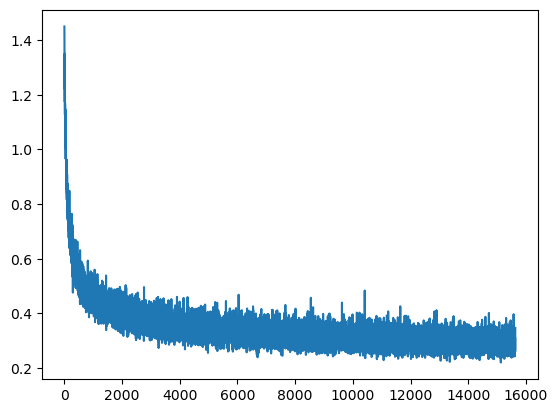

In [25]:
plt.plot(losses)